# Extrapolate scattering coeff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from importlib import reload
import pysm3
import astropy.units as u

import foscat.scat_cov as sc
import almscat.Sphere_lib as sphlib

2023-02-14 19:23:03.222067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 19:23:03.336853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 19:23:03.336873: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 19:23:04.063337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [24]:
# DEFINE A PATH FOR scratch data
# The data are stored using a default nside to minimize the needed storage
scratch_path = '../data'
nout = 256  # NSIDE

In [25]:
# Dust from PySM
# sky = pysm3.Sky(nside=nout, preset_strings=["d0"], output_unit="K_CMB")
# dust_maps = sky.get_emission(freq=np.array(400) * u.GHz)
# map = dust_maps[1, :].value  # Take Q and remove unit
#
# # Convert float64 to float32
# map = np.array(map, dtype=np.float32)
# # Normalize
# # map -= np.mean(map)
# # map /= np.std(map)
#
# print(f'Mean and STD: {np.mean(map):.3f} and {np.std(map):.3f}')
#
# # Convert from RING to NEST ordering
# im = hp.reorder(map, r2n=True)

In [89]:
im = hp.read_map('/home/lmousset/Ondelettes/SRoll40_FoCUS_353_full.fits', 1, nest=True)
# Normalization
im -= np.mean(im)
im /= np.std(im)
print(f'Mean and STD: {np.mean(im):.3f} and {np.std(im):.3f}')

# planet = 'venus'
# im = sphlib.make_hpx_planet(nside=nout, planet=planet, interp=True, normalize=True, nest=True)

# im = np.random.randn(12 * 256**2)


Mean and STD: -0.000 and 1.000


<Figure size 1000x600 with 0 Axes>

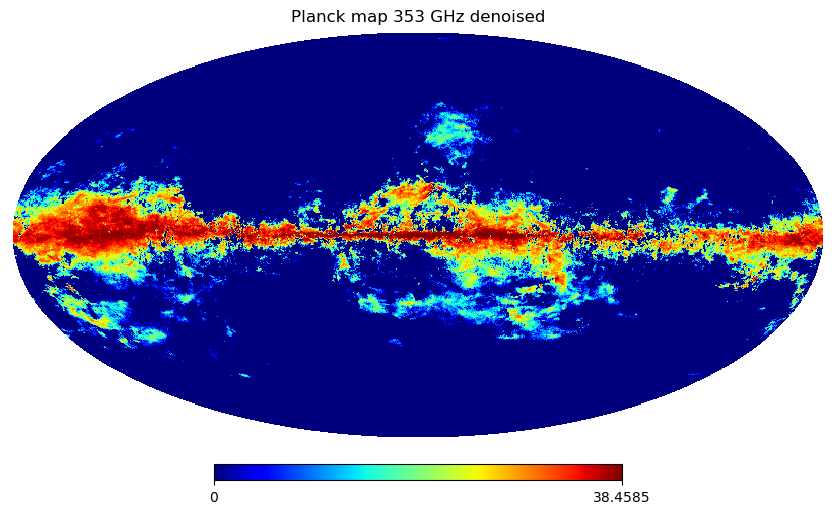

In [90]:
# Plot the map
plt.figure(figsize=(10, 6))
hp.mollview(im, cmap='jet', nest=True, title='Planck map 353 GHz denoised', min=0, max=None, norm='hist')

# Make a mask

(49152,) 64
(3, 49152)
(3, 786432)


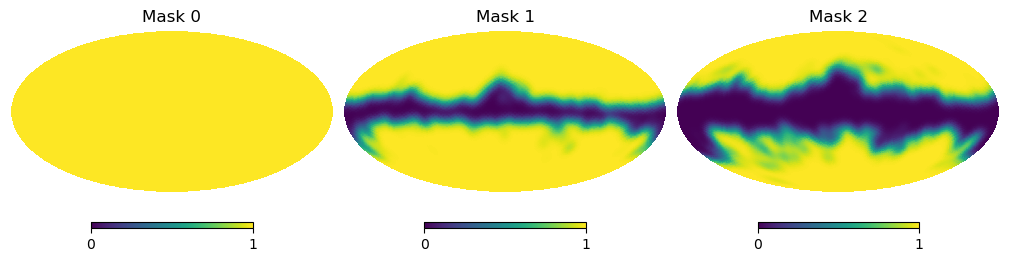

In [112]:
# Get the masks

mask3 = np.load('../example_JM/MASK_GAL060_64.npy')
mask2 = np.load('../example_JM/MASK_GAL080_64.npy')
mask1 = np.ones_like(mask2)

print(mask1.shape, hp.get_nside(mask1))

# Put the three masks in the same array
mask = np.array([mask1, mask2, mask3])
print(mask.shape)

# Set the mask at the good resolution
mask = hp.ud_grade(mask, nside_out=nout, order_in='NEST')
print(mask.shape)

# Plot the masks
plt.figure(figsize=(10, 6))
for i in range(3):
    hp.mollview(mask[i, :], nest=True, sub=(1, 3, i+1), title=f'Mask {i}', min=0, max=1)

# Initialize FOCUS class

In [92]:
reload(sc)
scat_op=sc.funct(NORIENT=3,   # define the number of wavelet orientation
                 KERNELSZ=5,  # define the kernel size (here 5x5)
                 OSTEP=2,     # get very large scale (nside=1)
                 LAMBDA=1.,  # 1 if KERNELSZ=5, 1.2 if KERNELSZ=3
                 TEMPLATE_PATH=scratch_path,
                 slope=1.,
                 use_R_format=False,
                 all_type='float32')


          START FOSCAT CONFIGURATION
Num GPUs Available:  0
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : CPU:0                          ==
==                                                        ==
==                                                        ==


# Compute scattering coeffs

In [93]:
scat_op.clean_norm()
refX = scat_op.eval(im, image2=None, mask=mask, norm=None)
print(refX)

S1 = refX.S1.numpy().squeeze()
P00 = refX.P00.numpy().squeeze()
C01 = refX.C01.numpy().squeeze()
C11 = refX.C11.numpy().squeeze()

print(S1.shape)

(3, 6, 3)


In [ ]:
# Number of scales and orientations
Nmasks, J, norient = np.shape(S1)
print(Nmasks, J, norient)


# Plot the coeffs

### All coeffs flatten

Text(0.5, 1.0, 'C11 imag')

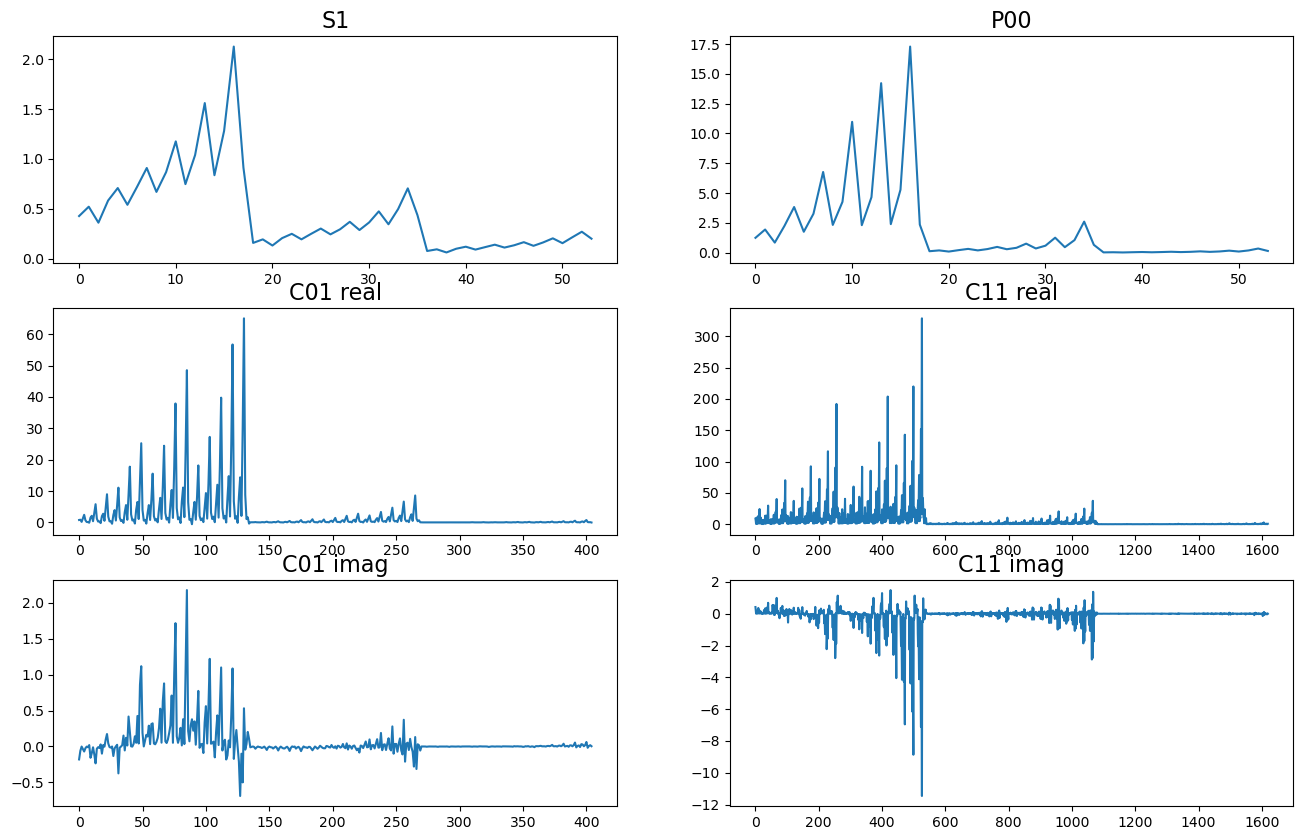

In [96]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10))
axs = axs.ravel()
axs[0].plot(S1.flatten())
axs[0].set_title('S1', fontsize=16)
axs[1].plot(P00.flatten())
axs[1].set_title('P00', fontsize=16)
axs[2].plot(np.real(C01).flatten())
axs[2].set_title('C01 real', fontsize=16)
axs[3].plot(np.real(C11).flatten())
axs[3].set_title('C11 real', fontsize=16)
axs[4].plot(np.imag(C01).flatten())
axs[4].set_title('C01 imag', fontsize=16)
axs[5].plot(np.imag(C11).flatten())
axs[5].set_title('C11 imag', fontsize=16)

### S1 and P00

In [127]:
# Choose the mask
m = 2  # Mask index

0.2949322428022112 -3.6566122486477792
0.6322779996054507 -5.470319237027846


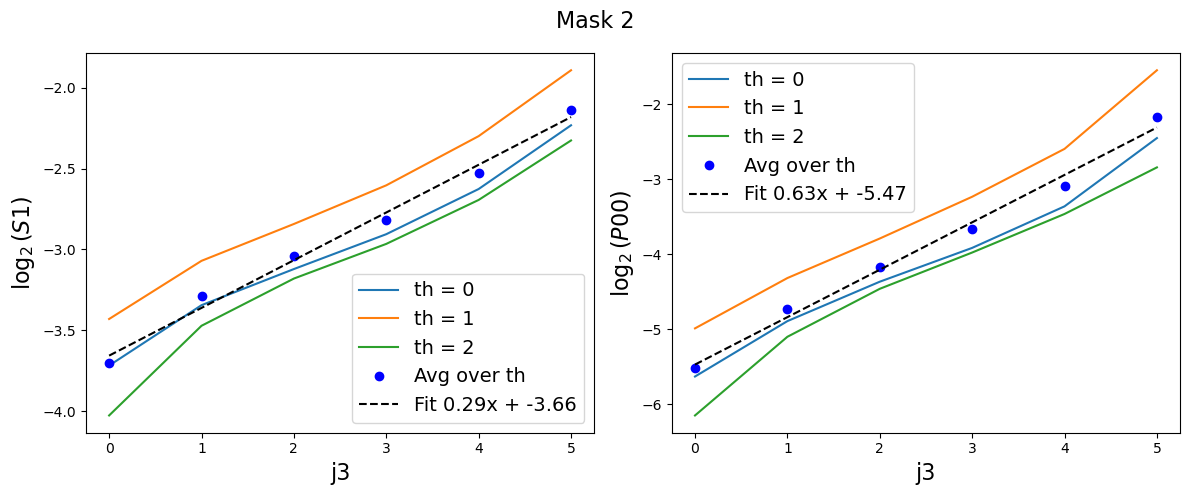

In [128]:
# Average over angles
S1mean = np.mean(S1, axis=-1)
P00mean = np.mean(P00, axis=-1)

# Linear fit
jj = np.arange(J)
aS1, bS1 = np.polyfit(jj, np.log2(S1mean[m, :]), deg=1)
aP00, bP00 = np.polyfit(jj, np.log2(np.real(P00mean[m, :])), deg=1)
print(aS1, bS1)
print(aP00, bP00)

# Plot S1 and P00
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax0, ax1 = axs.ravel()
fig.suptitle(f'Mask {m}', fontsize=16)


jj = np.arange(J)
for th in range(norient):
    ax0.plot(np.log2(S1[m, :, th]), label=f'th = {th}')
ax0.plot(np.log2(S1mean[m, :]), 'bo', label='Avg over th')
# ax0.plot(jj, -3*jj+2, 'k--', label='y = -3x + 2')
ax0.plot(jj, aS1 * jj + bS1, 'k--', label=f'Fit {aS1:.2f}x + {bS1:.2f}')
ax0.legend(fontsize=14)
ax0.set_ylabel(r'$\log_2(S1)$', fontsize=16)
ax0.set_xlabel('j3', fontsize=16)

for th in range(norient):
    ax1.plot(np.log2(P00[m, :, th]), label=f'th = {th}')
ax1.plot(np.log2(P00mean[m, :]), 'bo', label='Avg over th')
# ax1.plot(jj, -4*jj+4, 'k--', label='y = -4x + 4')
ax1.plot(jj, aP00 * jj + bP00, 'k--', label=f'Fit {aP00:.2f}x + {bP00:.2f}')
ax1.legend(fontsize=14)
ax1.set_ylabel(r'$\log_2(P00)$', fontsize=16)
ax1.set_xlabel('j3', fontsize=16)

fig.tight_layout()

### Plot C01

In [129]:
def make_jC01_array(J):
    # Build two arrays with j3, j2 values
    j3_C01, j2_C01 = [], []
    for j3 in range(J):
        for j2 in range(0, j3):
            j3_C01.append(j3)
            j2_C01.append(j2)
    j3_C01 = np.array(j3_C01)
    j2_C01 = np.array(j2_C01)
    return j3_C01, j2_C01

def search_C01(j3, j2, C01, J, m):
    if j2 > j3:
        raise ValueError('We must have j2 < j3.')
    # Build two arrays with j3, j2 values
    j3_C01, j2_C01 = make_jC01_array(J)

    # The two indices that satisfy the condition (real and imag)
    idx = np.where((j3_C01==j3) & (j2_C01==j2))[0]
    print(idx)

    c01 = C01[m, idx, :, :].squeeze()
    return c01

j3_C01, j2_C01 = make_jC01_array(J)
c01 = search_C01(4, 2, C01, J, m=0)
print(c01.shape)

[8]
(3, 3)


In [130]:
# for j3 in range(6):
#     for j2 in range(0, j3):
#         print(j3, j2)

In [131]:
C01.shape

(3, 15, 3, 3)

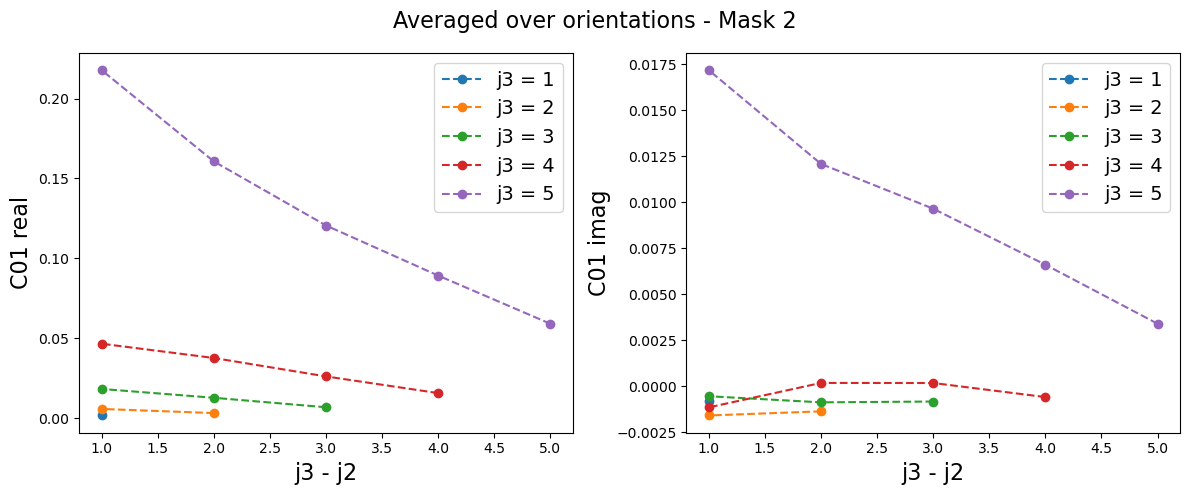

In [132]:
# Loop on j3 and average over orientations

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax0, ax1 = axs.ravel()
fig.suptitle(f'Averaged over orientations - Mask {m}', fontsize=16)

for j3 in range(1, J):
    toplot = np.mean(np.real(C01), axis=(-1, -2))[m, j3_C01 == j3]  # Average over orientations
    ax0.plot((j3_C01[j3_C01 == j3] - j2_C01[j3_C01 == j3]), toplot, 'o--', label=f'j3 = {j3}')
ax0.legend(fontsize=14)
# ax0.set_yscale('log')
ax0.set_ylabel('C01 real', fontsize=16)
ax0.set_xlabel('j3 - j2', fontsize=16)

for j3 in range(1, J):
    toplot = np.mean(np.imag(C01), axis=(-1, -2))[m, j3_C01 == j3]  # Average over orientations
    ax1.plot((j3_C01[j3_C01 == j3] - j2_C01[j3_C01 == j3]), toplot, 'o--', label=f'j3 = {j3}')
ax1.legend(fontsize=14)
# ax1.set_yscale('log')
ax1.set_ylabel('C01 imag', fontsize=16)
ax1.set_xlabel('j3 - j2', fontsize=16)

fig.tight_layout()

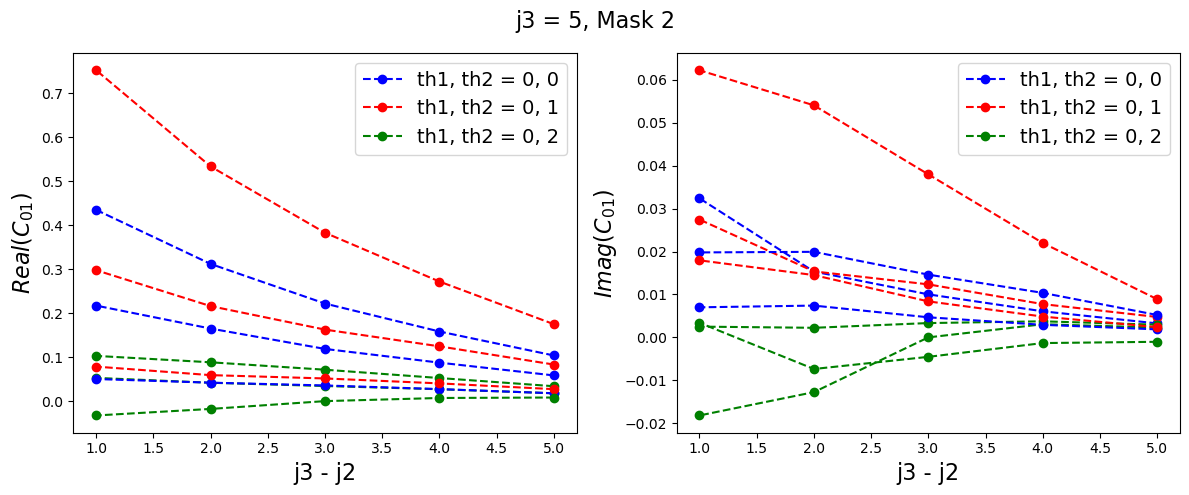

In [133]:
# Fix j3 and plot all orientations
j3 = 5

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax0, ax1 = axs.ravel()

fig.suptitle(f'j3 = {j3}, Mask {m}', fontsize=16)
color_list = ['b', 'r', 'g', 'orange']
for th1 in range(norient):
    for th2 in range(norient):
        x = (j3_C01[j3_C01 == j3] - j2_C01[j3_C01 == j3])
        y = np.real(C01[m, :, th1, th2])[j3_C01 == j3] # For a pair of orientations
        ax0.plot(x, y, 'o--', color=color_list[th2], label=f'th1, th2 = {th1}, {th2}')
    if th1 == 0:
        ax0.legend(fontsize=14, loc='best')
# ax0.set_yscale('log')
# ax0.set_ylabel(r'$2^{j_3-j_2} Real(C_{01})$', fontsize=16)
ax0.set_ylabel(r'$Real(C_{01})$', fontsize=16)
ax0.set_xlabel('j3 - j2', fontsize=16)


for th1 in range(norient):
    for th2 in range(norient):
        x = (j3_C01[j3_C01 == j3] - j2_C01[j3_C01 == j3])
        y = np.imag(C01[m, :, th1, th2])[j3_C01 == j3]  # For a pair of orientations
        ax1.plot(x, y, 'o--', color=color_list[th2], label=f'th1, th2 = {th1}, {th2}')
    if th1 == 0:
        ax1.legend(fontsize=14, loc='best')
# ax0.set_yscale('log')
# ax1.set_ylabel(r'$2^{j_3-j_2} Imag(C_{01})$', fontsize=16)
ax1.set_ylabel(r'$Imag(C_{01})$', fontsize=16)
ax1.set_xlabel('j3 - j2', fontsize=16)

fig.tight_layout()

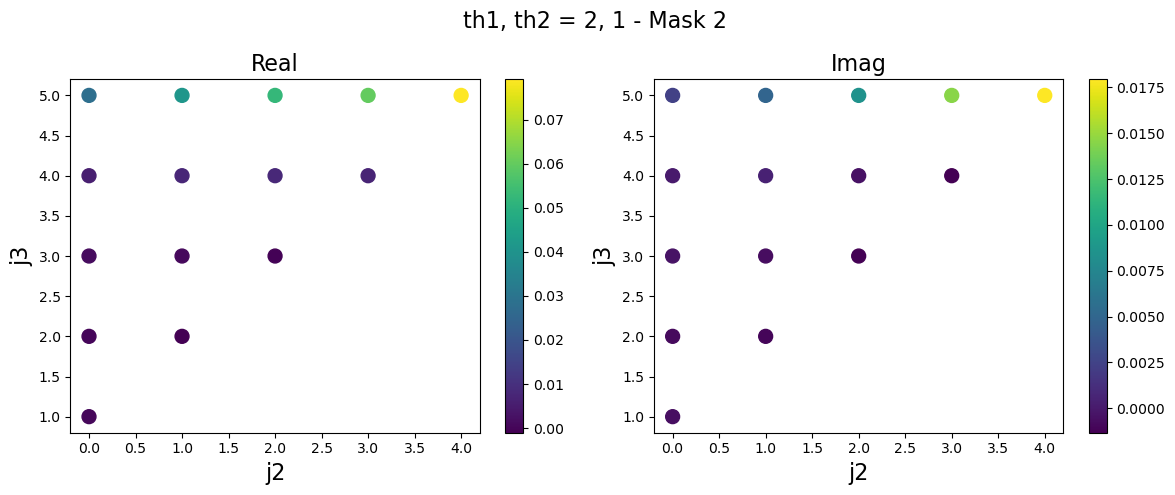

In [134]:
# Orientations
th1 = 2
th2 = 1

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax0, ax1 = axs.ravel()
fig.suptitle(f'th1, th2 = {th1}, {th2} - Mask {m}', fontsize=16)

im0 = ax0.scatter(j2_C01, j3_C01, s=100, c=np.real(C01[m, :, th1, th2]))
ax0.set_xlabel('j2', fontsize=16)
ax0.set_ylabel('j3', fontsize=16)
ax0.set_title('Real', fontsize=16)
fig.colorbar(im0)

im1 = ax1.scatter(j2_C01, j3_C01, s=100, c=np.imag(C01[m, :, th1, th2]))
ax1.set_xlabel('j2', fontsize=16)
ax1.set_ylabel('j3', fontsize=16)
ax1.set_title('Imag', fontsize=16)
fig.colorbar(im1)

fig.tight_layout()

[0]


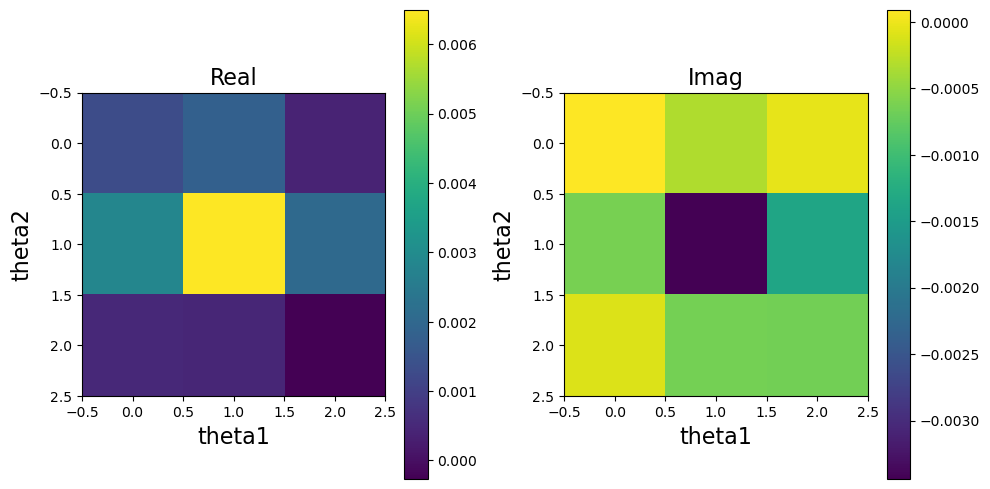

In [135]:
c01 = search_C01(1, 0, C01, J, m=m)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axs.ravel()

im1 = ax0.imshow(np.real(c01))
ax0.set_xlabel('theta1', fontsize=16)
ax0.set_ylabel('theta2', fontsize=16)
ax0.set_title('Real', fontsize=16)
fig.colorbar(im1)

im2 = ax1.imshow(np.imag(c01))
ax1.set_xlabel('theta1', fontsize=16)
ax1.set_ylabel('theta2', fontsize=16)
ax1.set_title('Imag', fontsize=16)
fig.colorbar(im2)

fig.tight_layout()

# Plot C11

In [136]:
def make_jC11_array(J):
    # Build two arrays with j3, j2 and j1 values
    j3_C11, j2_C11, j1_C11 = [], [], []
    for j3 in range(J):
        for j2 in range(0, j3):
            for j1 in range(0, j2):
                j3_C11.append(j3)
                j2_C11.append(j2)
                j1_C11.append(j1)
    j3_C11 = np.array(j3_C11)
    j2_C11 = np.array(j2_C11)
    j1_C11 = np.array(j1_C11)
    return j3_C11, j2_C11, j1_C11

def search_C11(j3, j2, j1, C11, J, m):
    if (j2 > j3) or (j1 > j2):
        raise ValueError('We must have j1 < j2 < j3.')
    # Build two arrays with j3, j2 values
    j3_C11, j2_C11, j1_C11 = make_jC11_array(J)

    # The three indices that satisfy the condition (real and imag)
    idx = np.where((j3_C11==j3) & (j2_C11==j2) & (j1_C11==j1))[0]

    c11 = C11[m, idx, :, :, :].squeeze()

    return c11

j3_C11, j2_C11, j1_C11 = make_jC11_array(J)
c11 = search_C11(j3=4, j2=2, j1=0, C11=C11, J=J, m=0)
print(c11.shape)

(3, 3, 3)


In [137]:
C11.shape

(3, 20, 3, 3, 3)

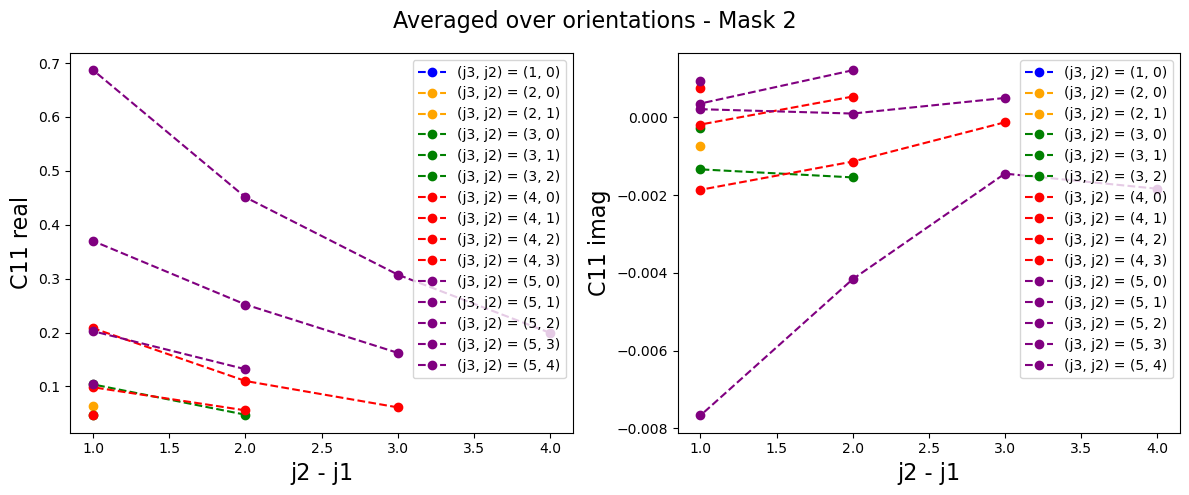

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax0, ax1 = axs.ravel()
fig.suptitle(f'Averaged over orientations - Mask {m}', fontsize=16)

color_list = ['b', 'orange', 'g', 'r', 'purple']
for j3 in range(1, J):
    for j2 in range(0, j3):
        cond = (j3_C11 == j3) & (j2_C11 == j2)
        x = (j2_C11[cond] - j1_C11[cond])
        y = (np.mean(np.real(C11), axis=(-1, -2, -3))[m, cond]) # Average over orientations
        ax0.plot(x, y, 'o--', color=color_list[j3-1], label=f'(j3, j2) = ({j3}, {j2})')
ax0.legend(fontsize=10)
# ax0.set_yscale('log')
ax0.set_ylabel('C11 real', fontsize=16)
ax0.set_xlabel('j2 - j1', fontsize=16)

for j3 in range(1, J):
    for j2 in range(0, j3):
        cond = (j3_C11 == j3) & (j2_C11 == j2)
        x = (j2_C11[cond] - j1_C11[cond])
        y = (np.mean(np.imag(C11), axis=(-1, -2, -3))[m, cond])  # Average over orientations
        ax1.plot(x, y, 'o--', color=color_list[j3-1], label=f'(j3, j2) = ({j3}, {j2})')
ax1.legend(fontsize=10)
# ax1.set_yscale('log')
ax1.set_ylabel('C11 imag', fontsize=16)
ax1.set_xlabel('j2 - j1', fontsize=16)

fig.tight_layout()

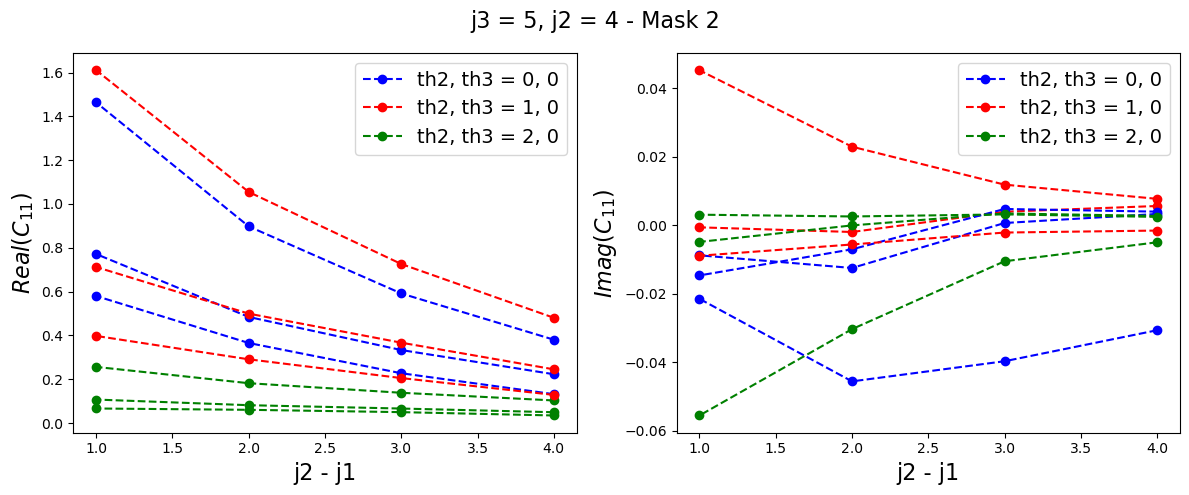

In [139]:
j3 = 5
j2 = 4

# Fix j3, j2 and plot all orientations
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax0, ax1 = axs.ravel()

fig.suptitle(f'j3 = {j3}, j2 = {j2} - Mask {m}', fontsize=16)
color_list = ['b', 'r', 'g', 'orange']
for th1 in range(norient):
    for th2 in range(norient):
        for th3 in range(1):
            cond = (j3_C11 == j3) & (j2_C11 == j2)
            x = (j2_C11[cond] - j1_C11[cond])
            y = np.real(C11[m, :, th1, th2, th3])[cond]
            ax0.plot(x, y, 'o--', color=color_list[th2], label=f'th2, th3 = {th2}, {th3}')
        if (th1 == 0):
            ax0.legend(fontsize=14, loc='upper right')
# ax0.set_yscale('log')
# ax0.set_ylabel(r'$2^{j_2-j_1} Real(C_{11})$', fontsize=16)
ax0.set_ylabel(r'$Real(C_{11})$', fontsize=16)
ax0.set_xlabel('j2 - j1', fontsize=16)

for th1 in range(norient):
    for th2 in range(norient):
        for th3 in range(1):
            cond = (j3_C11 == j3) & (j2_C11 == j2)
            x = (j2_C11[cond] - j1_C11[cond])
            y = np.imag(C11[m, :, th1, th2, th3])[cond]
            ax1.plot(x, y, 'o--', color=color_list[th2], label=f'th2, th3 = {th2}, {th3}')
        if (th1 == 0):
            ax1.legend(fontsize=14, loc='best')
# ax1.set_yscale('log')
# ax1.set_ylabel(r'$2^{j_2-j_1} Imag(C_{11})$', fontsize=16)
ax1.set_ylabel(r'$Imag(C_{11})$', fontsize=16)
ax1.set_xlabel('j2 - j1', fontsize=16)

fig.tight_layout()

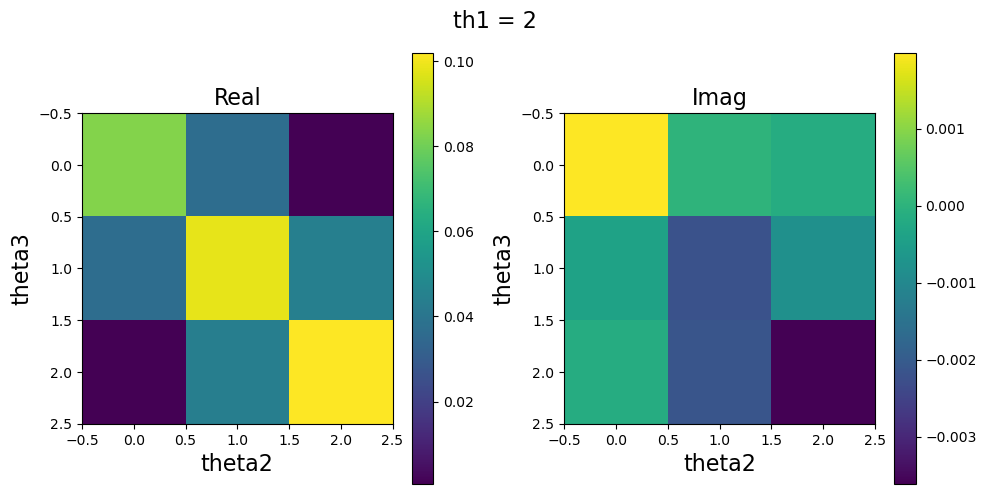

In [140]:
c11 = search_C11(2, 1, 0, C11, J, m=m)

th1 = 2
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axs.ravel()
fig.suptitle(f'th1 = {th1}', fontsize=16)

im1 = ax0.imshow(np.real(c11[th1, :, :]))
ax0.set_xlabel('theta2', fontsize=16)
ax0.set_ylabel('theta3', fontsize=16)
ax0.set_title('Real', fontsize=16)
fig.colorbar(im1)

im2 = ax1.imshow(np.imag(c11[th1, :, :]))
ax1.set_xlabel('theta2', fontsize=16)
ax1.set_ylabel('theta3', fontsize=16)
ax1.set_title('Imag', fontsize=16)
fig.colorbar(im2)

fig.tight_layout()

In [238]:
import pys2let